# A Classification Example Using a Simple CNN (with CIFAR-10 dataset)


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image


## Dataset prerequisites
These lines of code set up a pipeline that first converts images to the tensor format suitable for neural networks and then normalizes their pixel values to help with the efficient training of the network.


In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))] )


CIFAR-10 dataset contains 60,000 color images of 32x32 pixels, evenly divided into 10 classes (like cars, birds, cats, etc.), with 6,000 images per class. The dataset is split into 50,000 training images and 10,000 test images.

Below, we load the training portion of the CIFAR-10 dataset, download it to the specified folder if it's not there already, and apply the specified preprocessing steps to each image in the dataset.


In [3]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)


Files already downloaded and verified


This line of code sets up an efficient way to iterate through the training data, providing batches of four images at a time, shuffled for each epoch to improve learning, and using two parallel workers to ensure that data is always ready for the model to train on, minimizing downtime. 


In [4]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)


Apply same steps for the test set

In [5]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)


Files already downloaded and verified


## The Net Class
The Net class represents a specific architecture for a Convolutional Neural Network (CNN).
- 3 channels for RGB color images.
- 6 filters apply, 6 different feature maps, where each feature map is essentially a 2D array that represents some features detected in the input.
- 5 the size of the kernel.
- The second convolutional layer takes the 6 channels produced by conv1 as input and produces 16 output channels, also with a 5x5 kernel.
- A max pooling layer with a 2x2 window and stride of 2. 
- fc1, fc2, fc3: fully connected layers


In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)  # The output of the last pooling layer is flattened to transform it into a vector suitable for input into the fully connected layers.
        x = F.relu(self.fc1(x))  # apply the relu function after nn.Linear fully connected layer 1
        x = F.relu(self.fc2(x))  # # apply the relu function after nn.Linear fully connected layer 2
        x = self.fc3(x)  # outputs 10 classes
        return x


Initialize an Net() object:


In [7]:
net = Net()


**Cross-entropy loss** is a frequently employed loss function. Effectively combines a log softmax layer and the negative log likelihood (NLL) loss in one single class. This simplification reduces the complexity of the model's architecture and speeds up the computation, since it's more efficient to compute both operations at once rather than separately. It's designed to handle multi-class classification problems directly, without the need for manually encoding targets into a one-hot format. 

**Stochastic Gradient Descent**, is a fundamental and widely used optimization algorithm in training neural networks. It is a preferred choice due to its simplicity, efficiency, and effectiveness in a wide range of scenarios. It provides a good starting point for optimization and can be enhanced with additional features like momentum and learning rate scheduling to improve performance. Despite the development of more advanced optimization algorithms, SGD remains a fundamental tool in deep learning.


In [8]:
# Choose a loss function and an optimizer.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
epochs = 20  # An epoch represents one complete pass through the entire training dataset. 


## The Training

Train the CNN and calculate the losses:


In [9]:
epoch_losses = []  # List to store loss of each epoch
for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0  # At the start of each epoch, the running loss is reset to 0. This variable will accumulate the loss from each batch in the dataset, allowing you to calculate the average loss for the epoch.
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        # Before calculating the new gradients, existing gradients are reset to zero. Gradients accumulate by default, for correct parameter updates during backpropagation, but we need to clear them before computing gradients for the next batch.
        optimizer.zero_grad()  # zero the parameter gradients
        # The model processes the inputs through its forward method to produce predictions (outputs)
        outputs = net(inputs)
        # The loss function (criterion), which measures how well the model's predictions match the actual labels, is applied to compute the loss for the current batch.
        loss = criterion(outputs, labels)
        #  calculates the gradient of the loss function with respect to the model parameters by backpropagation. These gradients are used to adjust the model's parameters in the direction that minimally reduces the loss.
        loss.backward()
        # This applies the gradients computed by loss.backward() to update the model's parameters. The optimizer is responsible for adjusting the parameters based on the gradients to minimize the loss function.
        optimizer.step()
        # Adds the loss of the current batch to the running loss.
        running_loss += loss.item()
        
    # After processing all batches in the dataset for the epoch, the average loss is printed.
    epoch_loss = running_loss / len(trainloader)
    epoch_losses.append(epoch_loss)  # Append the average loss for this epoch to the list

    print(f"Epoch {epoch + 1}, Loss: {epoch_loss}")
    

Epoch 1, Loss: 1.7367538509654998
Epoch 2, Loss: 1.3365559113600851
Epoch 3, Loss: 1.1988036857235431
Epoch 4, Loss: 1.1073424127748608
Epoch 5, Loss: 1.0283525636919215
Epoch 6, Loss: 0.9719325646907836
Epoch 7, Loss: 0.9250440591047518
Epoch 8, Loss: 0.8886886762156337
Epoch 9, Loss: 0.8542175936505664
Epoch 10, Loss: 0.8263952195462095
Epoch 11, Loss: 0.8004937498525716
Epoch 12, Loss: 0.7785076144558424
Epoch 13, Loss: 0.7579943982198741
Epoch 14, Loss: 0.7335141221557453
Epoch 15, Loss: 0.7241916800330672
Epoch 16, Loss: 0.7077711045181163
Epoch 17, Loss: 0.6966320723192557
Epoch 18, Loss: 0.6843128217212164
Epoch 19, Loss: 0.6711470931260871
Epoch 20, Loss: 0.6596663421221657


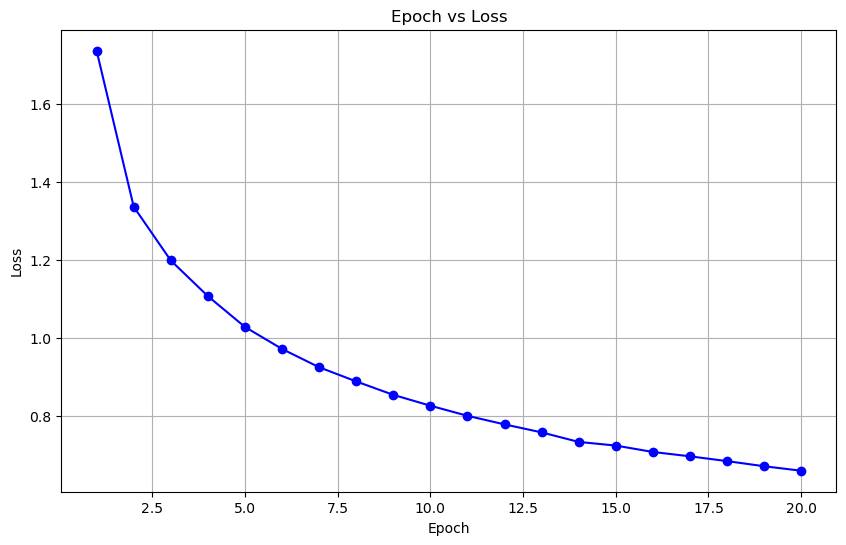

In [10]:
# Plotting the loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs+1), epoch_losses, marker='o', linestyle='-', color='blue')
plt.title('Epoch vs Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


## Evaluate the Model


In [11]:
correct = 0  # This initializes a counter for the number of predictions that the model gets right.
total = 0  # This initializes a counter for the total number of predictions made (or the total number of labels in the test dataset).


In [12]:
with torch.no_grad():  # we do not need to calculate gradients during this operation. Since we're only evaluating the model and not training it, we don't need gradients, which saves memory and computation.
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)  # This adds the number of labels in the current batch to the total count of labels. It effectively counts the number of test images processed so far.
        correct += (predicted == labels).sum().item()  # This calculates the number of correct predictions in the current batch by comparing predicted with labels. If a prediction matches the true label, it's counted as correct. .sum().item() adds up all the correct predictions to get a single number.

print(f"Accuracy on the test set: {(100 * correct / total):.2f}%")


Accuracy on the test set: 60.88%


In [13]:
# This line defines a variable PATH that stores the file path where the model's state dictionary should be saved. The file extension .pth is commonly used for PyTorch model files, but it's not a requirement; you could use another extension if you prefer. 
PATH = './model/cifar_net.pth'

# net.state_dict(): This method returns the model's state dictionary. The state dictionary is a Python dictionary object that maps each layer to its parameter tensor. Notably, the state dictionary contains weights and biases of the model layers, but it does not contain the model architecture itself. This means that when you load the model from this file, you'll need to have the model class (Net in your case) defined in your code.

# Save the model
torch.save(net.state_dict(), PATH)


## Use the Model for New Input

In [14]:
# Load the model
net = Net()
net.load_state_dict(torch.load(PATH))


<All keys matched successfully>

In [15]:
net.eval()
# Define the transformation
transform_im = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize the image to 32x32 pixels
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # These were the normalization values used during training
])


In [17]:
# Load and transform the image
image_path = './imgs_for_testing/bird.jpg'  # Update this to the path of your image
image = Image.open(image_path)
image = transform_im(image)
image = image.unsqueeze(0)  # Add a batch dimension


In [18]:
# Predict the class
outputs = net(image)
_, predicted = torch.max(outputs, 1)


In [19]:
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]


In [20]:
print(f'Predicted class: {cifar10_classes[predicted[0]]}')


Predicted class: bird
